In [3]:
import sys
from pathlib import Path

CODE_ROOT = Path().resolve().parent   
sys.path.insert(0, str(CODE_ROOT))

In [4]:
import open3d as o3d
import numpy as np
import pandas as pd
import copy
from src.preprocess import parse_obj_vertices, scan_obj_folder, prepare_clouds_scale_to_m
from src.viz import  visualize_ref_mov, visualize_single_gray, colorize_distance_to_ref, annotate_heatmap_png
from src.utils import load_T_from_json

### Dataset Statistics

In [6]:
path = "/Users/tuboshu/Downloads/prat_Data/2D/mov/B1G_10M_Transform.obj"

V = parse_obj_vertices(path)
print("OBJ v-lines:", V.shape[0])

mesh_np = o3d.io.read_triangle_mesh(path, enable_post_processing=False)
print("mesh.vertices (no post):", len(mesh_np.vertices), "tri:", len(mesh_np.triangles))

mesh_pp = o3d.io.read_triangle_mesh(path, enable_post_processing=True)
print("mesh.vertices (post):", len(mesh_pp.vertices), "tri:", len(mesh_pp.triangles))


OBJ v-lines: 1248903
[Open3D INFO] Skipping non-triangle primitive geometry of type: 8
mesh.vertices (no post): 2322932 tri: 2496252
[Open3D INFO] Skipping non-triangle primitive geometry of type: 20
mesh.vertices (post): 0 tri: 0


In [7]:
path = "/Users/tuboshu/Downloads/prat_Data/2D/mov"
voxel_size = 5  

results = scan_obj_folder(
        obj_dir=path,
        modality="photo",
        voxel_size=voxel_size,
        out_csv="../../Data/Results/dataset_stats_photo.csv"
)

print(results)

[OK]  photo |        v_lines | B1G_10M_Transform         | N= 1248903 | diag=3.04
[OK]  photo |        v_lines | B2G_10M_Transform         | N= 1250057 | diag=3.61
[OK]  photo |        v_lines | B3D_10M_Transform         | N= 1245388 | diag=3.18
[OK]  photo |        v_lines | B4D_10M_Transform         | N= 1244471 | diag=3.05
[OK]  photo |        v_lines | Dragon_01_Transform       | N= 1711170 | diag=1.36
[OK]  photo |        v_lines | Dragon_2_Transform        | N=  407808 | diag=1.39
[OK]  photo |        v_lines | Griffe_01_Transform       | N= 1527862 | diag=1.02
[OK]  photo |        v_lines | Griffe_2_Transform        | N= 1552494 | diag=1.03

Saved: ../Data/Results/dataset_stats_photo.csv
[{'modality': 'photo', 'name': 'B1G_10M_Transform', 'repr': 'v_lines', 'obj_path': '/Users/tuboshu/Downloads/prat_Data/2D/mov/B1G_10M_Transform.obj', 'n_raw_points': 1248903, 'bbox_diag': 3.0421886011408157, 'voxel_size': 5.0, 'n_down_points': 2, 'down_ratio': 1.6014053933732243e-06}, {'modality

In [9]:

path = "/Users/tuboshu/Downloads/prat_Data/3D"
voxel_size = 0.005  

results = scan_obj_folder(
        obj_dir=path,
        modality="laser",
        voxel_size=None,
        out_csv="../../Data/Results/dataset_stats_laser.csv"
)
print(results)


[OK]  laser |        v_lines | B1G_Complet               | N= 1805483 | diag=3.07e+03
[OK]  laser |        v_lines | B2G                       | N=  317567 | diag=3.58e+03
[OK]  laser |        v_lines | B3D                       | N=  314695 | diag=3.27e+03
[OK]  laser |        v_lines | B4D                       | N=  318820 | diag=3.13e+03
[OK]  laser |        v_lines | Cuisse                    | N=  142918 | diag=985
[OK]  laser |        v_lines | Montage Dragons           | N= 1397654 | diag=1.16e+04
[OK]  laser |        v_lines | Poutre_01_02              | N=  313561 | diag=3.8e+03
[OK]  laser |        v_lines | Poutre_01_1               | N=  312291 | diag=3.14e+03
[OK]  laser |        v_lines | Poutre_02_01bis           | N=  313667 | diag=4.07e+03
[OK]  laser |        v_lines | Poutre_02_2               | N=  315217 | diag=4.16e+03
[OK]  laser |        v_lines | Tete D                    | N= 1349372 | diag=1.31e+03
[OK]  laser |        v_lines | Tete G                    | N

### Visualization

In [11]:
mesh_photo = o3d.io.read_triangle_mesh("../../Data/ICP_test/move_Dragon_01_Transform.ply") # mov
mesh_laser = o3d.io.read_triangle_mesh("../../Data/ICP_test/ref_Tete_D.ply") # ref
aligned_geom = o3d.io.read_triangle_mesh("../../Data/ICP_test/dragon_after_landmark.ply") # aligned


visualize_ref_mov(
    ref_geom=mesh_laser,
    mov_geom=mesh_photo,
    aligned_geom=aligned_geom,
    out_png="../Img/registration_result.png"
)

[Open3D WARNING] geometry::TriangleMesh appears to be a geometry::PointCloud (only contains vertices, but no triangles).
Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to ../Img/registration_result.png


2026-02-03 12:42:21.259 python[90667:11376181] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [12]:
path = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Dragon_2_Transform.obj"
obj = o3d.io.read_triangle_mesh(path)
visualize_single_gray(obj)

Adjust the view, then press Q to save screenshot and exit.
Press S to save a screenshot at any time.


In [61]:
path = "/Users/tuboshu/Downloads/prat_Data/3D/Tete G.obj"
obj = o3d.io.read_triangle_mesh(path)
visualize_single_gray(obj)

Adjust the view, then press Q to save screenshot and exit.
Press S to save a screenshot at any time.
Saved screenshot to photo_Dragon_02.png


In [13]:
aligned_heat = colorize_distance_to_ref(aligned_geom, mesh_laser, max_dist=10.0)

print(type(aligned_heat))
print("has_colors:", aligned_heat.has_colors())
print("N points:", np.asarray(aligned_heat.points).shape[0])
print("colors range:", np.min(np.asarray(aligned_heat.colors)), np.max(np.asarray(aligned_heat.colors)))



<class 'open3d.cpu.pybind.geometry.PointCloud'>
has_colors: True
N points: 1711170
colors range: 0.0 1.0


In [14]:

aligned_heat = colorize_distance_to_ref(
    aligned_geom,
    mesh_laser,
    max_dist=10.0,   # 10 mm
)

visualize_ref_mov(
    ref_geom=mesh_laser,
    mov_geom=None,
    aligned_geom=aligned_heat,
    out_png="heat_map.png"
)

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to heat_map.png


### Visualize distance heatmap and save result

In [15]:
annotate_heatmap_png(
    in_png="heat_map.png",
    out_png="heat_annotated.png",
    max_dist_mm=10.0,
    cmap_name="jet",
    caption="Aligned photogrammetry (mov) vs laser scan (ref). Point-to-point distances are visualized; values above 10 mm are saturated."
)


Saved annotated figure: heat_annotated.png


## Metric Statistics Analysis

### Aggregate Result from ONE data MULTI runs

In [11]:
from src.analysis import run_analysis

stats, df_long, df_raw, df_fpfh, df_spin, df_combine, info = run_analysis(
    root="../../Data/Registrations/Poutre_02",
    stat_root="../p2p/Statistics/old/Poutre",
)

display(df_fpfh)
display(df_spin)
display(df_combine)

print(info["loaded_runs"], info["Ks"])
print(info["paths"])

,K,n_total,fpfh_n_success,fpfh_n_fail,fpfh_cov_5mm_mean,fpfh_cov_5mm_std,fpfh_cov_10mm_mean,fpfh_cov_10mm_std,fpfh_trimrmse_5mm_mean,fpfh_trimrmse_5mm_std,fpfh_trimrmse_10mm_mean,fpfh_trimrmse_10mm_std,fpfh_total_s_mean,fpfh_feat_s_mean,fpfh_ransac_s_mean,fpfh_icp_s_mean
0,10658,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.544249,2.174674,1.781815,1.587761
1,21316,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.323787,2.181580,5.535081,1.607127
2,42631,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.599442,2.200306,18.744700,1.654436
3,85263,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.352938,2.229692,109.460054,1.663192


,K,n_total,spinnet_n_success,spinnet_n_fail,spinnet_cov_5mm_mean,spinnet_cov_5mm_std,spinnet_cov_10mm_mean,spinnet_cov_10mm_std,spinnet_trimrmse_5mm_mean,spinnet_trimrmse_5mm_std,spinnet_trimrmse_10mm_mean,spinnet_trimrmse_10mm_std,spinnet_total_s_mean,spinnet_feat_s_mean,spinnet_ransac_s_mean,spinnet_icp_s_mean
0,10658,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.854114,126.929102,5.316534,1.608478
1,21316,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.554088,253.551678,19.400603,1.601806
2,42631,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,656.376867,561.119880,93.634159,1.622828
3,85263,5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1860.981914,1240.890963,618.408021,1.682930


,K,n_total,combine_n_success,combine_n_fail
0,10658,5,0,5
1,21316,5,0,5
2,42631,5,0,5
3,85263,5,0,5


20 [10658, 21316, 42631, 85263]
{'raw': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/raw_runs.csv', 'wide': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/summary_by_K_wide.csv', 'long': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/summary_by_K_long.csv', 'simpl_fpfh': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/summary_by_K_simplified_fpfh.csv', 'simpl_spinnet': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/summary_by_K_simplified_spinnet.csv', 'simpl_combine': '/Users/tuboshu/Documents/2025/M1/PRAT/Code/p2p/Statistics/old/Poutre/summary_by_K_simplified_combine.csv'}


### Aggregate ALL data runs

In [24]:
from src.analysis import aggregate_simplified_tables

fpfh_all, spinnet_all, combine_all, info = aggregate_simplified_tables("../p2p/Statistics")

print(info["n_fpfh_rows"], info["n_spinnet_rows"])
print("Missing FPFH:", info["missing_fpfh"])
print("Missing SpinNet:", info["missing_spinnet"])
print("Missing Combine:", info["missing_combine"])

32 32
Missing FPFH: []
Missing SpinNet: []
Missing Combine: []


In [13]:
STAT_ROOT = Path("../p2p/Statistics")
COMBINE_ROOT = Path("../p2p/Statistics")
fpfh_all.to_csv(STAT_ROOT / "fpfh_all.csv", index=False)
spinnet_all.to_csv(STAT_ROOT / "spinnet_all.csv", index=False)
combine_all.to_csv(COMBINE_ROOT / "combine_all.csv", index=False)

In [15]:
STAT_ROOT = Path("../Statistics")
COMBINE_ROOT = Path("../p2p/Statistics")
df_fpfh = pd.read_csv(STAT_ROOT / "fpfh_all.csv")
df_spin = pd.read_csv(STAT_ROOT / "spinnet_all.csv")
df_combine = pd.read_csv(COMBINE_ROOT / "combine_all.csv")


cols_fpfh = [
    "data_name",
    "K",
    "fpfh_cov_5mm_mean",
    "fpfh_cov_5mm_std",
    "fpfh_n_success",
    "fpfh_cov_10mm_mean",
    "fpfh_cov_10mm_std",
]

df_fpfh_view = df_fpfh[df_fpfh["K"] == "40%"][cols_fpfh]
display(df_fpfh_view)


,data_name,K,fpfh_cov_5mm_mean,fpfh_cov_5mm_std,fpfh_n_success,fpfh_cov_10mm_mean,fpfh_cov_10mm_std
24,B1G,40%,0.889174,6.537710e-07,4,0.959441,4.003513e-07
25,B2G,40%,NaN,NaN,0,NaN,NaN
26,B3D,40%,NaN,NaN,0,NaN,NaN
27,B4D,40%,NaN,NaN,0,NaN,NaN
28,Cuisse,40%,0.534995,NaN,1,0.788884,NaN
29,Poutre_02,40%,NaN,NaN,0,NaN,NaN
30,Tete_D_new,40%,NaN,NaN,0,NaN,NaN
31,Tete_G,40%,0.986242,1.096628e-06,5,0.997491,1.241267e-16


In [24]:
cols_fpfh = [
    "data_name",
    "K",
    "fpfh_trimrmse_5mm_mean",
    "fpfh_trimrmse_5mm_std",
    "fpfh_trimrmse_10mm_mean",
    "fpfh_trimrmse_10mm_std"
]
df_fpfh_view = df_fpfh[df_fpfh["K"] == "40%"][cols_fpfh]
display(df_fpfh_view)

,data_name,K,fpfh_trimrmse_5mm_mean,fpfh_trimrmse_5mm_std,fpfh_trimrmse_10mm_mean,fpfh_trimrmse_10mm_std
3,B1G,40%,0.002165,9.018297e-08,0.002815,5.161474e-08
7,B2G,40%,NaN,NaN,NaN,NaN
11,B3D,40%,NaN,NaN,NaN,NaN
15,B4D,40%,NaN,NaN,NaN,NaN
19,Cuisse,40%,NaN,NaN,NaN,NaN
23,Poutre,40%,NaN,NaN,NaN,NaN
27,Tete_D,40%,NaN,NaN,NaN,NaN
31,Tete_G,40%,0.001464,1.201540e-07,0.001623,1.072349e-07


In [32]:
cols_spin = [
    "data_name",
    "K",
    "spinnet_cov_5mm_mean",
    "spinnet_cov_5mm_std",
    "spinnet_cov_10mm_mean",
    "spinnet_cov_10mm_std",
    "spinnet_n_success"
]

df_spin_view = df_spin[df_spin["K"] == "40%"][cols_spin]
display(df_spin_view)

,data_name,K,spinnet_cov_5mm_mean,spinnet_cov_5mm_std,spinnet_cov_10mm_mean,spinnet_cov_10mm_std,spinnet_n_success
24,B1G,40%,0.889175,3.580851e-07,0.959441,0.000000e+00,5
25,B2G,40%,0.451867,7.929656e-04,0.820779,1.496508e-03,5
26,B3D,40%,0.637580,7.467984e-06,0.930071,7.394235e-06,5
27,B4D,40%,0.784329,3.993592e-06,0.940593,7.187208e-07,5
28,Cuisse,40%,NaN,NaN,NaN,NaN,0
29,Poutre_02,40%,NaN,NaN,NaN,NaN,0
30,Tete_D_new,40%,0.790703,5.226992e-07,0.816548,5.226992e-07,5
31,Tete_G,40%,NaN,NaN,NaN,NaN,0


In [28]:
cols_spin = [
    "data_name",
    "K",
    "spinnet_trimrmse_5mm_mean",
    "spinnet_trimrmse_5mm_std",
    "spinnet_trimrmse_10mm_mean",
    "spinnet_trimrmse_10mm_std",
]

df_spin_view = df_spin[df_spin["K"] == "40%"][cols_spin]
display(df_spin_view)

,data_name,K,spinnet_trimrmse_5mm_mean,spinnet_trimrmse_5mm_std,spinnet_trimrmse_10mm_mean,spinnet_trimrmse_10mm_std
3,B1G,40%,0.002165,2.472871e-07,0.002815,7.494301e-08
7,B2G,40%,0.003427,1.207623e-05,0.005403,4.929348e-06
11,B3D,40%,0.003344,1.123021e-05,0.004701,1.613373e-05
15,B4D,40%,0.002911,6.178510e-08,0.003809,6.654898e-08
19,Cuisse,40%,NaN,NaN,NaN,NaN
23,Poutre,40%,NaN,NaN,NaN,NaN
27,Tete_D,40%,0.001222,1.319201e-06,0.001758,1.064522e-06
31,Tete_G,40%,0.001464,1.756483e-08,0.001623,2.792160e-08


In [33]:
cols_combine = [
    "data_name",
    "K",
    "combine_cov_5mm_mean",
    "combine_cov_5mm_std",
    "combine_n_success",
    "combine_cov_10mm_mean",
    "combine_cov_10mm_std",
]

df_combine_view = df_combine[df_combine["K"] == "40%"][cols_combine]
display(df_combine_view)


,data_name,K,combine_cov_5mm_mean,combine_cov_5mm_std,combine_n_success,combine_cov_10mm_mean,combine_cov_10mm_std
3,B1G,40%,0.889088,0.000025,5,0.959408,0.000010
7,B2G,40%,0.452382,0.002894,5,0.818305,0.007316
11,B3D,40%,0.643582,0.001632,5,0.943581,0.007407
15,B4D,40%,0.784307,0.000056,5,0.940582,0.000009
19,Cuisse,40%,NaN,NaN,0,NaN,NaN
23,Poutre,40%,NaN,NaN,0,NaN,NaN
27,Tete_D,40%,0.790704,0.000004,5,0.816546,0.000005
31,Tete_G,40%,0.986241,0.000038,2,0.997489,0.000003


In [34]:
cols_combine = [
    "data_name",
    "K",
    "combine_trimrmse_5mm_mean",
    "combine_trimrmse_5mm_std",
    "combine_trimrmse_10mm_mean",
    "combine_trimrmse_10mm_std",
]
df_combine_view = df_combine[df_combine["K"] == "40%"][cols_combine]
display(df_combine_view)

,data_name,K,combine_trimrmse_5mm_mean,combine_trimrmse_5mm_std,combine_trimrmse_10mm_mean,combine_trimrmse_10mm_std
3,B1G,40%,0.002165,1.316962e-07,0.002815,2.946051e-08
7,B2G,40%,0.003430,1.004809e-05,0.005401,5.593428e-06
11,B3D,40%,0.003342,1.725015e-05,0.004704,1.400049e-05
15,B4D,40%,0.002911,1.991812e-07,0.003809,1.353306e-07
19,Cuisse,40%,NaN,NaN,NaN,NaN
23,Poutre,40%,NaN,NaN,NaN,NaN
27,Tete_D,40%,0.001221,1.884851e-07,0.001758,1.950518e-07
31,Tete_G,40%,0.001464,1.079541e-06,0.001624,7.961468e-07


In [36]:
cols_combine = [
    "data_name",
    "K",
    # "combine_cov_5mm_mean",
    # "combine_cov_5mm_std",
    "combine_total_s_mean",
    "combine_n_success",
]

df_combine_view = df_combine[cols_combine]
display(df_combine_view)

,data_name,K,combine_total_s_mean,combine_n_success
0,B1G,5%,420.667287,5
1,B1G,10%,1157.958194,5
2,B1G,20%,3122.727110,5
3,B1G,40%,9450.471616,5
4,B2G,5%,138.479738,5
5,B2G,10%,306.233292,5
6,B2G,20%,833.608718,5
7,B2G,40%,2722.089631,5
8,B3D,5%,144.807820,5
9,B3D,10%,288.297200,5


In [17]:
cols_combine = [
    "data_name",
    "K",
    "combine_feat_s_mean",
    "combine_ransac_s_mean",
    "combine_icp_s_mean",
    "combine_total_s_mean",
]

df_combine_view = df_combine[cols_combine]
display(df_combine_view)
df_combine_view.to_csv(COMBINE_ROOT / "combine_all_time.csv", index=False)

,data_name,K,combine_feat_s_mean,combine_ransac_s_mean,combine_icp_s_mean,combine_total_s_mean
0,B1G,5%,367.735798,45.879845,7.051644,420.667287
1,B1G,10%,751.950570,398.102850,7.904774,1157.958194
2,B1G,20%,1381.880635,1732.729331,8.117144,3122.727110
3,B1G,40%,2741.713451,6700.242636,8.515529,9450.471616
4,B2G,5%,123.238040,7.539331,7.702367,138.479738
5,B2G,10%,255.588991,41.928516,8.715786,306.233292
6,B2G,20%,497.931178,329.817301,5.860239,833.608718
7,B2G,40%,1028.974385,1686.472321,6.642925,2722.089631
8,B3D,5%,126.508441,6.938466,11.360912,144.807820
9,B3D,10%,244.944644,33.593215,9.759341,288.297200


In [15]:
STAT_ROOT = Path("../p2p/Statistics/old")
df_fpfh = pd.read_csv(STAT_ROOT / "fpfh_all.csv")

df_spin = pd.read_csv(STAT_ROOT / "spinnet_all.csv")


cols_fpfh = [
    "data_name",
    "K",
    "fpfh_feat_s_mean",
    "fpfh_ransac_s_mean",
    "fpfh_icp_s_mean",
    "fpfh_total_s_mean",
]

df_fpfh_view = df_fpfh[cols_fpfh]
display(df_fpfh_view)
df_fpfh_view.to_csv(STAT_ROOT / "fpfh_all_time.csv", index=False)

,data_name,K,fpfh_feat_s_mean,fpfh_ransac_s_mean,fpfh_icp_s_mean,fpfh_total_s_mean
0,B1G,5%,3.620869,5.674580,17.239340,26.534788
1,B1G,10%,3.588461,22.893523,14.294551,40.776535
2,B1G,20%,3.732190,128.268460,7.860854,139.861504
3,B1G,40%,3.558840,562.212699,7.740677,573.512216
4,B2G,5%,2.290881,1.881918,6.548479,10.721279
5,B2G,10%,2.261538,6.377831,6.503338,15.142707
6,B2G,20%,2.205630,21.357637,6.417427,29.980693
7,B2G,40%,2.303047,124.563013,6.225408,133.091468
8,B3D,5%,2.206078,1.733927,1.518401,5.458406
9,B3D,10%,2.066043,5.403002,1.503210,8.972255


In [17]:
cols_spinnet = [
    "data_name",
    "K",
    "spinnet_feat_s_mean",
    "spinnet_ransac_s_mean",
    "spinnet_icp_s_mean",
    "spinnet_total_s_mean",
]

df_spinnet_view = df_spin[cols_spinnet]
display(df_spinnet_view)
df_spinnet_view.to_csv(STAT_ROOT / "spinnet_all_time.csv", index=False)

,data_name,K,spinnet_feat_s_mean,spinnet_ransac_s_mean,spinnet_icp_s_mean,spinnet_total_s_mean
0,B1G,5%,388.149599,9.749800,4.546206,402.445604
1,B1G,10%,781.910838,38.279569,4.460931,824.651338
2,B1G,20%,1466.490549,248.150170,4.313560,1718.954279
3,B1G,40%,2809.408685,983.220456,4.412042,3797.041183
4,B2G,5%,124.211443,3.044982,4.551454,131.807879
5,B2G,10%,240.335438,10.375351,4.165961,254.876750
6,B2G,20%,467.528253,37.247050,4.854110,509.629413
7,B2G,40%,951.373127,252.143960,5.555702,1209.072789
8,B3D,5%,126.677533,2.488615,4.700360,133.866508
9,B3D,10%,240.558896,8.218591,3.949567,252.727055


### Visualize raw obj from out.json 

In [33]:
json_path = "../result/FPFH_SpinNet/Tete_G/K_3072/seed_4/out.json"  
mov_obj  = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Dragon_2_Transform.obj"
ref_obj  = "/Users/tuboshu/Downloads/prat_Data/3D/Tete G.obj" 

# 1) load T 
T_fpfh = load_T_from_json(json_path, "fpfh_T_icp")
T_spin = load_T_from_json(json_path, "spinnet_T_icp")

# 2) reproduce the same preprocessing used in the experiment
ref_full, mov_full, _, _ = prepare_clouds_scale_to_m(ref_obj, mov_obj, scale_to_m=1e-3, voxel_size=0.005)

# 3) apply T to mov_full 
mov_spin = copy.deepcopy(mov_full)
mov_spin.transform(T_spin)

mov_fpfh = copy.deepcopy(mov_full)
mov_fpfh.transform(T_fpfh)



PointCloud with 407808 points.

In [34]:
# 4) visualize 
visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_spin, out_png="TeteG_k5_SpinNet_seed4.png")
# visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh)

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to TeteG_k5_SpinNet_seed4.png


In [35]:
visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh, out_png="TeteG_k5_FPFH_seed4.png")

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to TeteG_k5_FPFH_seed4.png


In [36]:
json_path = "../result/Combine/Tete_G/K_3072/seed_3/out.json"  
mov_obj  = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Dragon_2_Transform.obj"
ref_obj  = "/Users/tuboshu/Downloads/prat_Data/3D/Tete G.obj" 

# 1) load T 
T_combine = load_T_from_json(json_path, "combine_T_icp")

# 2) reproduce the same preprocessing used in the experiment
ref_full, mov_full, _, _ = prepare_clouds_scale_to_m(ref_obj, mov_obj, scale_to_m=1e-3, voxel_size=0.005)

# 3) apply T to mov_full 
mov_combine = copy.deepcopy(mov_full)
mov_combine.transform(T_combine)

# 4) visualize 
visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_combine, out_png="TeteG_k5_Combine_seed3.png")

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to TeteG_k5_Combine_seed3.png


In [13]:
annotate_heatmap_png(
    in_png="B2G_up.png",
    out_png="B2G_up_heat.png",
    max_dist_mm=10.0,
    cmap_name="jet",
    caption="P2P distances visualization between ref and mov. Values above 10 mm are saturated."
)

Saved annotated figure: B2G_up_heat.png


: 

In [5]:
json_path = "../../Data/Registrations/Cuisse/K_14558/seed_0/out.json"  
mov_obj  = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Griffe_2_Transform.obj"
ref_obj  = "/Users/tuboshu/Downloads/prat_Data/3D/Cuisse.obj" 

# 1) load T 
T_fpfh = load_T_from_json(json_path, "fpfh_T_icp")
T_spin = load_T_from_json(json_path, "spinnet_T_icp")

# 2) reproduce the same preprocessing used in the experiment
ref_full, mov_full, _, _ = prepare_clouds_scale_to_m(ref_obj, mov_obj, scale_to_m=1e-3, voxel_size=0.005)

# 3) apply T to mov_full 
mov_spin = copy.deepcopy(mov_full)
mov_spin.transform(T_spin)

mov_fpfh = copy.deepcopy(mov_full)
mov_fpfh.transform(T_fpfh)

# 4) visualize 
visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh, out_png="B1G/B1G_FPFH_K5.png")

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)
Saved screenshot to cuisse_back.png


In [6]:
annotate_heatmap_png(
    in_png="cuisse_back.png",
    out_png="cuisse_back_heat.png",
    max_dist_mm=10.0,
    cmap_name="jet",
    caption="P2P distances visualization between ref and mov. Values above 10 mm are saturated."
)


Saved annotated figure: cuisse_back_heat.png


In [78]:
visualize_ref_mov(ref_geom=ref_full, mov_geom=mov_fpfh, aligned_geom=None)

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)


In [79]:
visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh)

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)


In [114]:
json_path = "../../Data/Registrations/Tete_D_new/K_10485/seed_0/out.json"  
mov_obj  = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Dragon_01_Transform.obj"
ref_obj  = "/Users/tuboshu/Downloads/prat_Data/3D/Tete D.obj" 

# 1) load T 
T_fpfh = load_T_from_json(json_path, "fpfh_T_icp")
T_spin = load_T_from_json(json_path, "spinnet_T_icp")

# 2) reproduce thesame preprocessing used in the experiment
ref_full, mov_full = prepare_clouds_scale_to_m(ref_obj, mov_obj, scale_to_m=1e-3, voxel_size=0.005)

# 3) apply T to mov_full 
mov_spin = copy.deepcopy(mov_full)
# mov_spin.transform(T_spin)

mov_fpfh = copy.deepcopy(mov_full)
# mov_fpfh.transform(T_fpfh)

# 4) visualize 
visualize_ref_mov(ref_geom=ref_full, mov_geom=mov_fpfh)
# visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh)

Adjust the view, then press Q to save screenshot and exit. (Press S to save anytime.)


In [3]:
json_path = "../../Data/Registrations/B1G/K_22402/seed_0/out.json"  
mov_obj  = "/Users/tuboshu/Downloads/prat_Data/2D/mov/Dragon_2_Transform.obj"
ref_obj  = "/Users/tuboshu/Downloads/prat_Data/3D/Tete G.obj" 

# 2) reproduce the same preprocessing used in the experiment
mov_full = o3d.io.read_triangle_mesh(mov_obj)
visualize_single_gray(mov_full, out_png="laser_dragon_02.png")
# visualize_ref_mov(ref_geom=ref_full, mov_geom=None, aligned_geom=mov_fpfh)

Adjust the view, then press Q to save screenshot and exit.
Press S to save a screenshot at any time.
Saved screenshot to laser_dragon_02.png


2026-02-06 09:44:01.697 python[5983:97896] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [4]:
ref_full = o3d.io.read_triangle_mesh(ref_obj)
visualize_single_gray(ref_full, out_png="photo_tete_G.png")

Adjust the view, then press Q to save screenshot and exit.
Press S to save a screenshot at any time.
Saved screenshot to photo_tete_G.png


### Computation Time Analysis

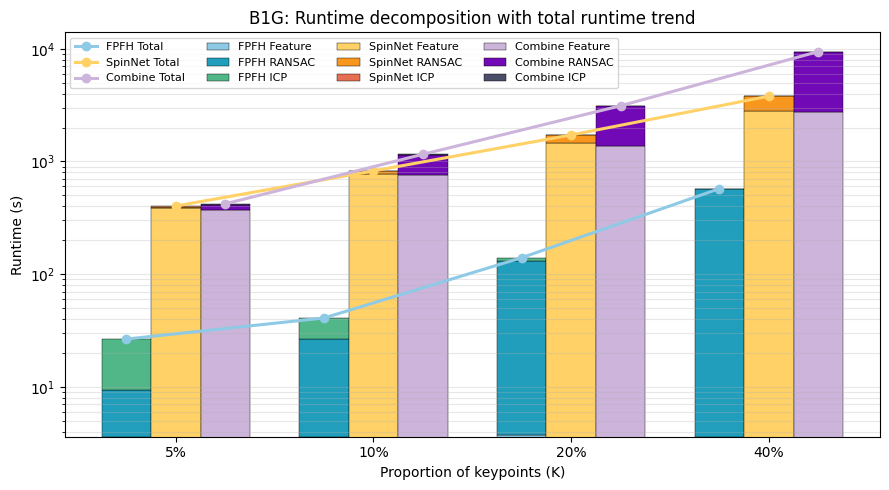

In [2]:
import numpy as np
import matplotlib.pyplot as plt

K_labels = ["5%", "10%", "20%", "40%"]
x = np.arange(len(K_labels))

data = {
    "FPFH": {
        "Feature": [3.6, 3.6, 3.7, 3.6],
        "RANSAC":  [5.7, 22.9, 128.3, 562.2],
        "ICP":     [17.2, 14.3, 7.9, 7.7],
        "Total":   [26.5, 40.8, 139.9, 573.5],
    },
    "SpinNet": {
        "Feature": [388.1, 781.9, 1466.5, 2809.4],
        "RANSAC":  [9.7, 38.3, 248.2, 983.2],
        "ICP":     [4.5, 4.5, 4.3, 4.4],
        "Total":   [402.4, 824.7, 1719.0, 3797.0],
    },
    "Combine": {
        "Feature": [367.7, 752.0, 1381.9, 2741.7],
        "RANSAC":  [45.9, 398.1, 1732.7, 6700.2],
        "ICP":     [7.1, 7.9, 8.1, 8.5],
        "Total":   [420.7, 1158.0, 3122.7, 9450.5],
    }
}

width = 0.25
methods = ["FPFH", "SpinNet", "Combine"]
offsets = [-width, 0.0, width]

colors = {
    "FPFH": {
        "Feature": "#8ecae6",
        "RANSAC":  "#219ebc",
        "ICP":     "#52b788",
    },
    "SpinNet": {
        "Feature": "#ffd166",
        "RANSAC":  "#f8961e",
        "ICP":     "#e76f51",
    },
    "Combine": {
        "Feature": "#cdb4db",
        "RANSAC":  "#7209b7",
        "ICP":     "#4a4e69",
    },
}

plt.figure(figsize=(9, 5))

for i, method in enumerate(methods):
    feat = np.array(data[method]["Feature"])
    ran  = np.array(data[method]["RANSAC"])
    icp  = np.array(data[method]["ICP"])
    total = np.array(data[method]["Total"])

    xpos = x + offsets[i]

    plt.bar(
        xpos, feat, width=width,
        color=colors[method]["Feature"],
        edgecolor="black", linewidth=0.3,
        label=f"{method} Feature",
    )
    plt.bar(
        xpos, ran, width=width, bottom=feat,
        color=colors[method]["RANSAC"],
        edgecolor="black", linewidth=0.3,
        label=f"{method} RANSAC",
    )
    plt.bar(
        xpos, icp, width=width, bottom=feat + ran,
        color=colors[method]["ICP"],
        edgecolor="black", linewidth=0.3,
        label=f"{method} ICP",
    )

    
    plt.plot(
        xpos, total,
        color=colors[method]["Feature"],   
        marker="o",
        linewidth=2.2,
        markersize=6,
        zorder=6,
        label=f"{method} Total",
    )

plt.xticks(x, K_labels)
plt.xlabel("Proportion of keypoints (K)")
plt.ylabel("Runtime (s)")
plt.title("B1G: Runtime decomposition with total runtime trend")
plt.yscale("log")
plt.grid(True, which="both", axis="y", alpha=0.3)


plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()
